In [1]:
library(tidyverse)
library(Rtsne)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
read_expression <- function(tumor) {
    xpr <- lapply(c('Case', 'Control'), function(x) paste0('../data/expression/', tumor, '_', x, '_isoform_tpm.tsv')) %>%
       lapply(read_tsv)         
    dims <- lapply(xpr, function(x) ncol(x) - 1)
    xpr <- inner_join(xpr[[1]], xpr[[2]], by = 'transcript')
    txs <- xpr$transcript
    xpr <- select(xpr, -transcript) %>% data.matrix
    row.names(xpr) <- txs
    colnames(xpr) <- c(rep('Case', dims[1]), rep('Control', dims[2]) )
    xpr <- xpr[!duplicated(xpr),]
                  
    return(t(xpr))
}
                   
plot_tSNE <- function(x, title) {
    y <- rownames(x)
    Rtsne(x, dims = 2, perplexity=30, verbose=TRUE, max_iter = 500) %>%
    .$Y %>%
    as_tibble %>%
    mutate(label = y, x = V1, y = V2) %>%
    ggplot(aes(x = x, y = y, color = label)) +
        geom_point() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(title = title, color = 'Origin')
}

In [3]:
all <- read_expression('ALL')
all_plt <- plot_tSNE(all, 'ALL')

aml <- read_expression('AML')
aml_plt <- plot_tSNE(aml, 'AML')

Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.


Read the 156 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Normalizing input...
Building tree...
 - point 0 of 156
Done in 0.02 seconds (sparsity = 0.748932)!
Learning embedding...
Iteration 50: error is 57.141332 (50 iterations in 0.06 seconds)
Iteration 100: error is 59.355894 (50 iterations in 0.07 seconds)
Iteration 150: error is 58.624478 (50 iterations in 0.08 seconds)
Iteration 200: error is 60.091220 (50 iterations in 0.07 seconds)
Iteration 250: error is 58.504812 (50 iterations in 0.06 seconds)
Iteration 300: error is 1.405608 (50 iterations in 0.05 seconds)
Iteration 350: error is 0.861547 (50 iterations in 0.05 seconds)
Iteration 400: error is 0.608738 (50 iterations in 0.06 seconds)
Iteration 450: error is 0.586077 (50 iterations in 0.05 seconds)
Iteration 500: error is 0.584837 (50 iterations in 0.05 seconds)
Fitting performed in 0.60 seconds.


Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.


Read the 167 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Normalizing input...
Building tree...
 - point 0 of 167
Done in 0.02 seconds (sparsity = 0.709455)!
Learning embedding...
Iteration 50: error is 57.555504 (50 iterations in 0.06 seconds)
Iteration 100: error is 60.439658 (50 iterations in 0.07 seconds)
Iteration 150: error is 60.390450 (50 iterations in 0.06 seconds)
Iteration 200: error is 59.897227 (50 iterations in 0.06 seconds)
Iteration 250: error is 58.661289 (50 iterations in 0.07 seconds)
Iteration 300: error is 1.422481 (50 iterations in 0.06 seconds)
Iteration 350: error is 0.837186 (50 iterations in 0.05 seconds)
Iteration 400: error is 0.656024 (50 iterations in 0.05 seconds)
Iteration 450: error is 0.598486 (50 iterations in 0.05 seconds)
Iteration 500: error is 0.589960 (50 iterations in 0.05 seconds)
Fitting performed in 0.58 seconds.


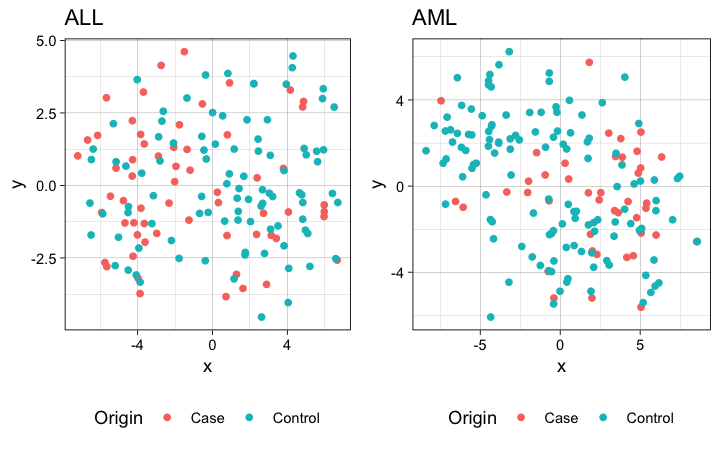

In [4]:
options(repr.plot.width=6, repr.plot.height=3.75)
plot_grid(all_plt, aml_plt)